# Spark Exploration

In [1]:
import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

import warnings 
warnings.filterwarnings("ignore")

spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [2]:
# Use the wrangle function provided by Zach to prepare and
# combine the 311 dataset.
df = wrangle_311(spark)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments


In [3]:
# Display the shape of the spark dataframe
print(f'There are {df.count():,} observations and {len(df.columns)} features.')

There are 841,704 observations and 20 features.


# Exercise Questions

In [4]:
# Display a single observation to the collective features represent.
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



## 1. How many different cases are there, by department?

>To answer this question, we'll need to use: `groupby()` and `countDistinct()`. We want to find the number of different (meaning: DISTINCT) cases each department handles. This will give us information to consider when looking at open/close, late/not late case time differences.
```python
(
# We groupby the department column to set it as our index (meaning: Observations we're looking for)
df.groupby('department')
    
# We use the aggregate function to collect values by passing a function
.agg(
    # The function we pass is `countDistinct()`. It counts the number of distinct values
    # in a column. In our case 'service_request_type'.
    countDistinct('service_request_type')
    
    # Give the aggregation an alias for presentation.
    .alias('distinct_cases'))
    
# Sort by the department column for presentation.
.sort('department')
    
# Display the results without truncating strings longer than 20 characters.
.show(truncate=False)
)
```

In [5]:
# Answer with inline comments removed.
(
    df.groupby('department')
    .agg(countDistinct('service_request_type').alias('distinct_cases'))
    .sort('department')
    .show(truncate=False)
)

+------------------------+--------------+
|department              |distinct_cases|
+------------------------+--------------+
|Animal Care Services    |14            |
|City Council            |2             |
|Customer Service        |2             |
|DSD/Code Enforcement    |122           |
|Metro Health            |14            |
|Parks & Recreation      |44            |
|Solid Waste             |56            |
|Trans & Cap Improvements|81            |
+------------------------+--------------+



## 2. Does the percentage of cases that are late vary by department?
> To answer this question let's first establish what were looking for:<br>
__Percentage of cases that are late by department__<br>

This one was a bit challenging.

```python
(
# Group the dataframe by the department column to set it as the index
# ->The observation we're looking for: 'departments.
df.groupby('department')

# We pivot the 'case_late' column to create a new dataframe
# 'case_late' values: True if a case is late, False otherwise.
.pivot('case_late')

# Use the count function to total the number of late cases and on-time cases.
.count()
    
# Select the 'department' column for context from the pivoted dataframe.
.select('department',

        # Calculate the proportion of late cases per department.
        # Formula per department: total late cases / total cases.
        # Round for presentation
        round((col('true') / (col('true') + col('false'))), 3)
        
        # Alias the calculation for context and presentation
        .alias('pct_cases_late'))
    
# City council had 0 missing cases. Fill with 0.
.na.fill(0)
    
# Sort by department for presentation
.sort('department')
    
# display the results
.show()
)
```

In [6]:
# Answer with inline comments removed.
df_department_pct_late_cases = (

    df.groupby('department')
      .pivot('case_late')
    .count()
    .select('department',
            round((col('true')
                   / (col('true') + col('false')))
                  , 6)
            .alias('pct_cases_late'))
    
    .na.fill(0)
    .sort('department')
)

df_department_pct_late_cases.show(truncate=False)

+------------------------+--------------+
|department              |pct_cases_late|
+------------------------+--------------+
|Animal Care Services    |0.199085      |
|City Council            |0.0           |
|Customer Service        |0.705511      |
|DSD/Code Enforcement    |0.081634      |
|Metro Health            |0.160566      |
|Parks & Recreation      |0.190737      |
|Solid Waste             |0.117968      |
|Trans & Cap Improvements|0.056251      |
+------------------------+--------------+



In [239]:
(
    df.groupby('department')
    .pivot('case_late')
    .count()
    .select('department',
             round((col('true') / (col('true') + col('false'))), 6).alias('pct_cases_late'))
    .na.fill(0)
    .sort('department')
    .show(truncate=False)
)

+------------------------+--------------+
|department              |pct_cases_late|
+------------------------+--------------+
|Animal Care Services    |0.199085      |
|City Council            |0.0           |
|Customer Service        |0.705511      |
|DSD/Code Enforcement    |0.081634      |
|Metro Health            |0.160566      |
|Parks & Recreation      |0.190737      |
|Solid Waste             |0.117968      |
|Trans & Cap Improvements|0.056251      |
+------------------------+--------------+



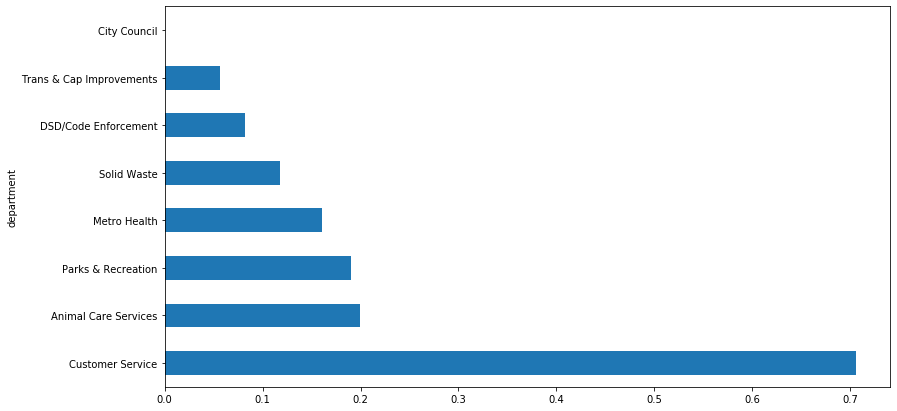

In [7]:
(
    df_department_pct_late_cases
    .toPandas()
    .set_index('department')
    ['pct_cases_late'].sort_values(ascending=False)
    .plot.barh(figsize=(13, 7))
);

## 3. On average, how late are the late cases by department?

In [20]:
(
    df.filter(col('case_late') == True).groupby('department')
    .agg(round(mean('num_days_late')).alias('avg_days_late'))
    .sort('department')
    .na.fill(0)
    .show()
)

+--------------------+-------------+
|          department|avg_days_late|
+--------------------+-------------+
|Animal Care Services|         23.0|
|    Customer Service|         88.0|
|DSD/Code Enforcement|         49.0|
|        Metro Health|          7.0|
|  Parks & Recreation|         22.0|
|         Solid Waste|          7.0|
|Trans & Cap Impro...|         11.0|
+--------------------+-------------+



## 4. What is the service type that is the most late? Just for Parks & Rec?

In [27]:
(
    df.filter(col('case_late') == True).groupby('department', 'service_request_type')
    .agg(round(mean('num_days_late')).alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .na.fill(0)
    .show(1, truncate=False)
)

+--------------------+--------------------+-------------+
|department          |service_request_type|avg_days_late|
+--------------------+--------------------+-------------+
|DSD/Code Enforcement|Zoning: Recycle Yard|211.0        |
+--------------------+--------------------+-------------+
only showing top 1 row



In [28]:
(
    df.filter(col('case_late') == True)
    .filter(col('department') == 'Parks & Recreation')
    .groupby('service_request_type')
    .agg(round(mean('num_days_late')).alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .na.fill(0)
    .show(1, truncate=False)
)

+------------------------+-------------+
|service_request_type    |avg_days_late|
+------------------------+-------------+
|Amenity Park Improvement|77.0         |
+------------------------+-------------+
only showing top 1 row



## 5. For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

In [35]:
(
    df.filter(col('department') == 'DSD/Code Enforcement')
    .groupby('service_request_type')
    .count()
    .sort(desc('count'))
    .show(10, truncate=False)
)

+--------------------------------------+-----+
|service_request_type                  |count|
+--------------------------------------+-----+
|Overgrown Yard/Trash                  |65895|
|Bandit Signs                          |32910|
|Front Or Side Yard Parking            |28794|
|Junk Vehicle On Private Property      |21473|
|Alley-Way Maintenance                 |20214|
|Right Of Way/Sidewalk Obstruction     |17699|
|Vacant Lot/Overgrown/Trash            |9329 |
|Minimum Housing-Owner Occupied        |8543 |
|Graffiti: Private Property (Corridors)|8525 |
|Dang. Premises/CL/SEC                 |8004 |
+--------------------------------------+-----+
only showing top 10 rows



In [61]:
department_names = list(df.select('department').toPandas()['department'].unique())

In [68]:
for name in department_names:
    print(f'Department: {name}')
    
    (
    df.filter(col('department') == f'{name}')
    .groupby('service_request_type')
    .count()
    .sort(desc('count'))
    .show(5, truncate=False)
    )
    print('')

Department: Animal Care Services
+-------------------------------+-----+
|service_request_type           |count|
+-------------------------------+-----+
|Stray Animal                   |26760|
|Aggressive Animal(Non-Critical)|24882|
|Animal Neglect                 |13441|
|Trapped/Confined Animal        |11354|
|Public Nuisance(Own Animal)    |10715|
+-------------------------------+-----+
only showing top 5 rows


Department: Trans & Cap Improvements
+----------------------------------------------+-----+
|service_request_type                          |count|
+----------------------------------------------+-----+
|Pot Hole Repair                               |20616|
|Traffic Signal Ops and Maintenance - Emergency|7997 |
|Traffic Sign Missing/Down                     |5674 |
|Base/Pavement Repair                          |5385 |
|Signal Timing Modification                    |4414 |
+----------------------------------------------+-----+
only showing top 5 rows


Department: DSD/Code En

## 6. Does whether or not its a weekend matter for when a case is opened/closed?

In [136]:
(
    df.select(when(dayofweek('case_opened_date').isin([1,7]).cast("int") == 0, 'weekday')
              .otherwise('weekend').alias('day_of_week_opened'),
              when(dayofweek('case_closed_date').isin([1,7]).cast("int") == 0, 'weekday')
              .otherwise('weekend').alias('day_of_week_closed'))
    .filter(col('case_closed') == True)
    .groupby('day_of_week_opened', 'day_of_week_closed')
    .count()
    .sort('day_of_week_opened', 'day_of_week_closed')
    .show()
)

+------------------+------------------+------+
|day_of_week_opened|day_of_week_closed| count|
+------------------+------------------+------+
|           weekday|           weekday|690853|
|           weekday|           weekend| 51353|
|           weekend|           weekday| 44714|
|           weekend|           weekend| 36674|
+------------------+------------------+------+



In [258]:
day_of_week_opened_closed = (
    
    df.select(when(dayofweek('case_opened_date').isin([1,7]).cast("int") == 0, 'weekday')
              .otherwise('weekend').alias('day_of_week_opened'),
              when(dayofweek('case_closed_date').isin([1,7]).cast("int") == 0, 'weekday')
              .otherwise('weekend').alias('day_of_week_closed'))
    .filter(col('case_closed') == True)
    .groupby('day_of_week_opened', 'day_of_week_closed')
    .count()
    .withColumnRenamed('count', 'cases')
    .sort('day_of_week_opened', 'day_of_week_closed')
)

In [260]:
df_dow = day_of_week_opened_closed.toPandas()

df_dow = df_dow.assign(
    opened_closed = df_dow.day_of_week_opened + '-' + df_dow.day_of_week_closed
)

df_dow = df_dow.drop(columns=['day_of_week_opened', 'day_of_week_closed'])

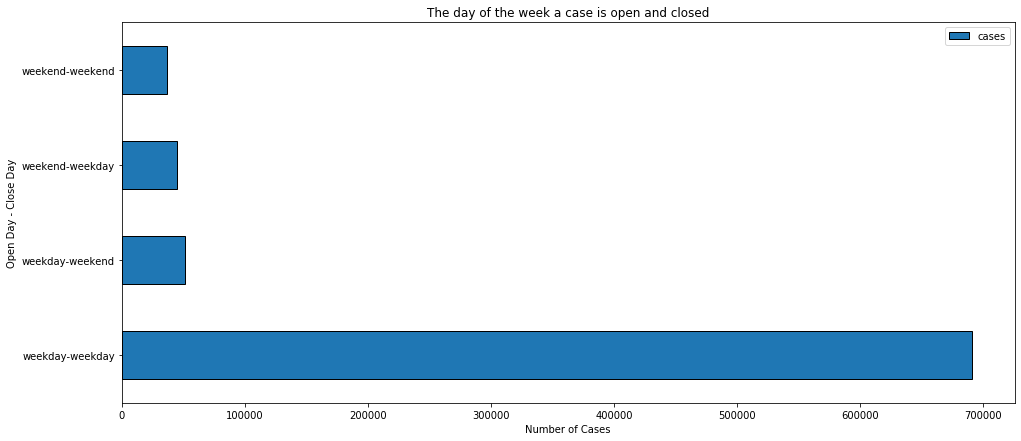

In [270]:
df_dow.set_index('opened_closed').plot.barh(figsize=(16, 7), ec='black')
plt.title('The day of the week a case is open and closed')
plt.xlabel('Number of Cases')
plt.ylabel('Open Day - Close Day');

## 7. On average, how many cases are opened a day for the Customer Service department?

In [251]:
(    
    df.filter(col('department') == 'Customer Service')
    .select(concat(dayofweek(col('case_opened_date')), lit('-'), date_format(col('case_opened_date'), 'EEEE')).alias('day_of_week'))
    .groupby('day_of_week')
    .count()
    .withColumnRenamed('count', 'cases_opened')
    .sort('day_of_week')
    .show()
)

+-----------+------------+
|day_of_week|cases_opened|
+-----------+------------+
|   1-Sunday|          36|
|   2-Monday|         444|
|  3-Tuesday|         630|
|4-Wednesday|         465|
| 5-Thursday|         560|
|   6-Friday|         546|
| 7-Saturday|         168|
+-----------+------------+



In [250]:
print('The average number of cases opened by the Customer Service department')
(    
    df.filter(col('department') == 'Customer Service')
    .groupby(dayofweek('case_opened_date').alias('day_of_week_opened'))
    .count()
    .agg(avg('count').alias('daily_average_cases_opened'))
    .show()
)

The average number of cases opened by the Customer Service department
+--------------------------+
|daily_average_cases_opened|
+--------------------------+
|                     407.0|
+--------------------------+



## 8. Does the number of service requests for the solid waste department vary by day of the week?

In [209]:
solid_waste_weekly_requests = (
    df.filter(col('department') == 'Solid Waste')
        .select(weekofyear(col('case_opened_date')).alias('request_week_of_year'))
        .groupby('request_week_of_year')
        .count()
        .withColumnRenamed('count', 'Cases')
        .sort('request_week_of_year')
)

In [210]:
solid_waste_weekly_requests.show(5)

+--------------------+-----+
|request_week_of_year|Cases|
+--------------------+-----+
|                   1| 5955|
|                   2| 6689|
|                   3| 5198|
|                   4| 6214|
|                   5| 6346|
+--------------------+-----+
only showing top 5 rows



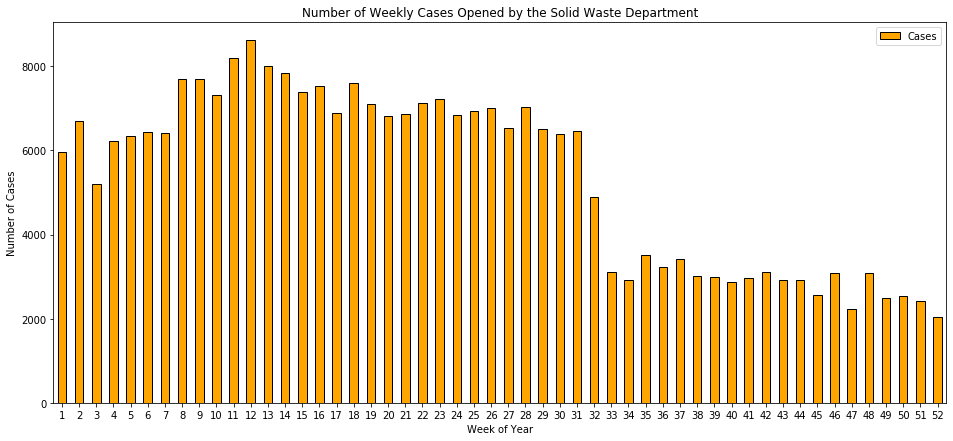

In [213]:
(
    solid_waste_weekly_requests
    .toPandas().set_index('request_week_of_year')
    .plot.bar(figsize=(16, 7),
              rot=0,
              color='orange',
              ec='black'),
    plt.title('Number of Weekly Cases Opened by the Solid Waste Department'),
    plt.xlabel('Week of Year'),
    plt.ylabel('Number of Cases')
);